In [1]:
import os
import json
import math
import numpy as np
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.utils import save_image
from torchvision.datasets import FashionMNIST
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.nn.functional import one_hot

from pytorch_fid import fid_score

/tmp/ipykernel_208493/2475230352.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


In [3]:
transform = v2.Compose(
    [
     v2.ToTensor(),
     v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

train_data = ImageFolder('./trafic_32', transform=transform)
train_classes = train_data.classes
train_classes = [name.lstrip('0') if name != '00000' else '0' for name in train_classes]

/home/michal/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [4]:
train_loader = data.DataLoader(train_data, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)

In [5]:
data, classes = next(iter(train_loader))
data.size()

torch.Size([256, 3, 32, 32])

## VAE

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                      # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat

In [9]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim + 43, hidden_dim = hidden_dim, output_dim = x_dim)


    def reparameterization(self, mean, var):
        z = torch.rand(1).to(device) * var + mean
        return z


    def forward(self, x, one_hot_class):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        z = torch.concat((z, one_hot_class), dim=1)

        x_hat = self.decoder(z)
        return x_hat, mean, log_var

## Training

In [10]:
vae = VAE(latent_dim=16, hidden_dim=256, x_dim=3072).to(device)

In [11]:
encoding = one_hot(torch.arange(0, 43), 43)

torch.Size([43])

In [12]:
def get_classes_encoded(train_classes: list, classes_names: list, encoding):
    return torch.stack([encoding[train_classes.index(str(name.item()))] for name in classes_names], dim=0)

In [13]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [14]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [15]:
epochs_losses = []
num_epochs = 200
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        # x = x.to(device)

        classes_encoded = get_classes_encoded(train_classes, _, encoding)
        out, means, log_var = vae(x, classes_encoded)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epochs_losses.append(np.mean(np.array(losses_epoch)))
    print(f"Epoch {n} loss {epochs_losses[-1]}")
    scheduler.step()

Epoch 0 loss 370017.139501634, test L1 = nan


/home/michal/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/michal/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 1 loss 332310.43280228757, test L1 = nan
Epoch 2 loss 323349.7308006536, test L1 = nan
Epoch 3 loss 320058.737745098, test L1 = nan
Epoch 4 loss 316647.01102941175, test L1 = nan
Epoch 5 loss 313695.64195261436, test L1 = nan
Epoch 6 loss 311321.82169117645, test L1 = nan
Epoch 7 loss 309567.2553104575, test L1 = nan
Epoch 8 loss 308343.71854575165, test L1 = nan
Epoch 9 loss 307029.702001634, test L1 = nan
Epoch 10 loss 306005.50020424835, test L1 = nan
Epoch 11 loss 304996.68402777775, test L1 = nan


KeyboardInterrupt: 

In [16]:
def get_train_images(num):
    return torch.stack([train_data[i][0] for i in range(10,10+num)], dim=0)

In [17]:
input_imgs = get_train_images(8)

In [18]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    rmd_to_genrate = torch.randn([n_imgs, model.latent_dim])
    classes_to_generate = torch.concat((rmd_to_genrate, encoding[:n_imgs]), dim=1)
    with torch.no_grad():
        generated_imgs = model.decoder(classes_to_generate).to(device)
    generated_imgs = generated_imgs.cpu()


    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

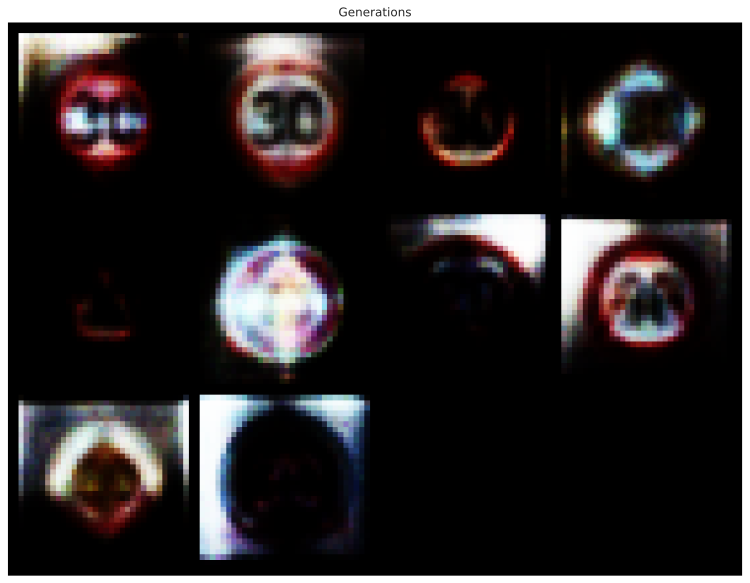

In [19]:
generate_images(vae, 10, device)

In [48]:
def im_save(img, path):
    img = img / 2 + 0.5     # unnormalize
    save_image(img, path)

def evaluate_model(model, train_data, encoding: list, train_classes):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
    images, labels = next(iter(train_loader))
    rmd_to_genrate = torch.randn([10, model.latent_dim])
    encoded_classes = get_classes_encoded(train_classes, labels, encoding)

    classes_to_generate = torch.concat((rmd_to_genrate, encoded_classes), dim=1)
    with torch.no_grad():
        generated_imgs = model.decoder(classes_to_generate).to(device)
    generated_imgs = generated_imgs.cpu()
    for i, img in enumerate(generated_imgs):
        im_save(img, f'gen_eval/img{i}.jpg')
    for i, img in enumerate(images):
        im_save(img, f'real_eval/img{i}.jpg')
    paths = ['/home/michal/sem6/ssne/ssne/real_eval, /home/michal/sem6/ssne/ssne/gen_eval']
    return fid_score.calculate_fid_given_paths(paths, batch_size=200, device='cpu', dims=2048)


In [49]:
evaluate_model(vae, train_data, encoding, train_classes)

RuntimeError: Invalid path: /home/michal/sem6/ssne/ssne/real_eval, /home/michal/sem6/ssne/ssne/gen_eval